In [1]:
%matplotlib inline
import scrublet as scr
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import pandas as pd

#### Download and uncompress data

In [2]:
!wget https://kleintools.hms.harvard.edu/tools/scrublet/data/demuxlet_PBMCs.tar.gz
!tar xfz demuxlet_PBMCs.tar.gz

--2018-07-16 16:39:54--  https://kleintools.hms.harvard.edu/tools/scrublet/data/demuxlet_PBMCs.tar.gz
Resolving kleintools.hms.harvard.edu (kleintools.hms.harvard.edu)... 134.174.150.16
Connecting to kleintools.hms.harvard.edu (kleintools.hms.harvard.edu)|134.174.150.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19294450 (18M) [application/x-tar]
Saving to: ‘demuxlet_PBMCs.tar.gz’

demuxlet_PBMCs.tar. 100%[===================>]  18.40M  6.23MB/s    in 3.0s    

2018-07-16 16:39:57 (6.23 MB/s) - ‘demuxlet_PBMCs.tar.gz’ saved [19294450/19294450]



#### Load counts matrix, gene list, and demuxlet calls

In [3]:
data_dir = './demuxlet_PBMCs/'
E = scipy.sparse.load_npz(data_dir + 'GSM2560248_matrix.npz')
genes = np.array(scr.load_genes(data_dir + 'GSM2560248_genes.tsv', column=1))
demuxlet_table = pd.read_table(data_dir + 'demuxlet_calls.tsv')
demuxlet_calls = np.array(demuxlet_table['Call']) == 'DBL'

#### Calculate doublet scores
We'll compare two preprocessing strategies that differ only in the gene-level normalization (scaling) prior to PCA:
z-score and log

In [4]:
# filtering/preprocessing parameters:
min_counts = 3
min_cells = 3
vscore_percentile = 85
n_pc = 30

# doublet detector parameters:
expected_doublet_rate = sum(demuxlet_calls) / float(len(demuxlet_calls))
sim_doublet_ratio = 2
n_neighbors = 50

In [5]:
# z-score normalization

t0 = time.time()

scrublet_results_zNorm = scr.compute_doublet_scores(
    E, 
    min_counts = min_counts, 
    min_cells = min_cells, 
    vscore_percentile = vscore_percentile, 
    n_prin_comps = n_pc,
    scaling_method = 'zscore',
    expected_doublet_rate = expected_doublet_rate,
    sim_doublet_ratio = sim_doublet_ratio,
    n_neighbors = n_neighbors, 
    use_approx_neighbors = True, 
)

t1 = time.time()
print('Elapsed time: {:.1f} seconds'.format(t1 - t0))

Simulating doublets
Total counts normalizing
Finding highly variable genes
Filtering genes from 35635 to 1345
Applying z-score normalization
Running PCA
Building kNN graph and calculating doublet scores
Elapsed time: 15.6 seconds


In [6]:
# log normalization

t0 = time.time()

scrublet_results_logNorm = scr.compute_doublet_scores(
    E, 
    min_counts = min_counts, 
    min_cells = min_cells, 
    vscore_percentile = vscore_percentile, 
    n_prin_comps = n_pc,
    scaling_method = 'log',
    expected_doublet_rate = expected_doublet_rate,
    sim_doublet_ratio = sim_doublet_ratio,
    n_neighbors = n_neighbors, 
    use_approx_neighbors = True, 
)

t1 = time.time()
print('Elapsed time: {:.1f} seconds'.format(t1 - t0))

Simulating doublets
Total counts normalizing
Finding highly variable genes
Filtering genes from 35635 to 1345
Applying log normalization
Running PCA
Building kNN graph and calculating doublet scores
Elapsed time: 14.5 seconds


#### Get UMAP embedding to help visualize the results

In [7]:
# UMAP: https://github.com/lmcinnes/umap
import umap

embedding_zNorm = umap.UMAP(n_neighbors=10).fit_transform(scrublet_results_zNorm['pca_observed_cells'])
embedding_logNorm = umap.UMAP(n_neighbors=10).fit_transform(scrublet_results_logNorm['pca_observed_cells'])

#### Set doublet score threshold and visualize results
To call doublets, manually set a threshold between the two peaks of the simulated doublet histogram.

1181/14619 = 8.1% of cells are predicted doublets.
53.1% of doublets are predicted to be detectable.
Predicted overall doublet rate = 15.2%


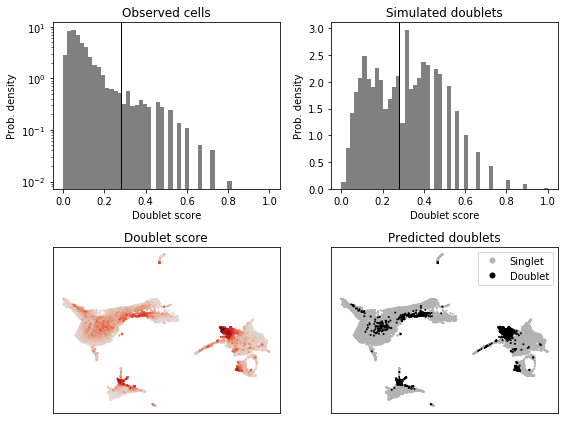

In [8]:
# z-score normalization
score_threshold_zNorm = 0.28
fig, axs = scr.plot_scrublet_results(embedding_zNorm, 
                                     scrublet_results_zNorm['doublet_scores_observed_cells'], 
                                     scrublet_results_zNorm['doublet_scores_simulated_doublets'], 
                                     score_threshold_zNorm, 
                                     order_points = True, 
                                     marker_size = 4)

For the log-normalized version, the simulated doublet score histogram is less bimodal. Set the threshold to cut off the left tail.

1838/14619 = 12.6% of cells are predicted doublets.
87.6% of doublets are predicted to be detectable.
Predicted overall doublet rate = 14.4%


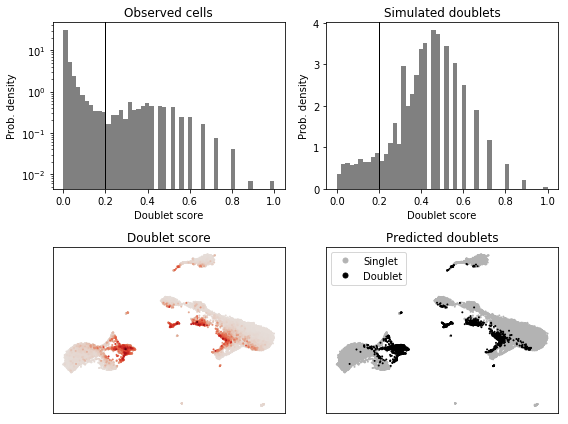

In [9]:
# log normalization

score_threshold_logNorm = 0.2
fig, axs = scr.plot_scrublet_results(embedding_logNorm, 
                                     scrublet_results_logNorm['doublet_scores_observed_cells'], 
                                     scrublet_results_logNorm['doublet_scores_simulated_doublets'], 
                                     score_threshold_logNorm, 
                                     order_points = True, 
                                     marker_size = 4)

Compare predicted doublets to "ground truth" demuxlet calls on UMAP embedding

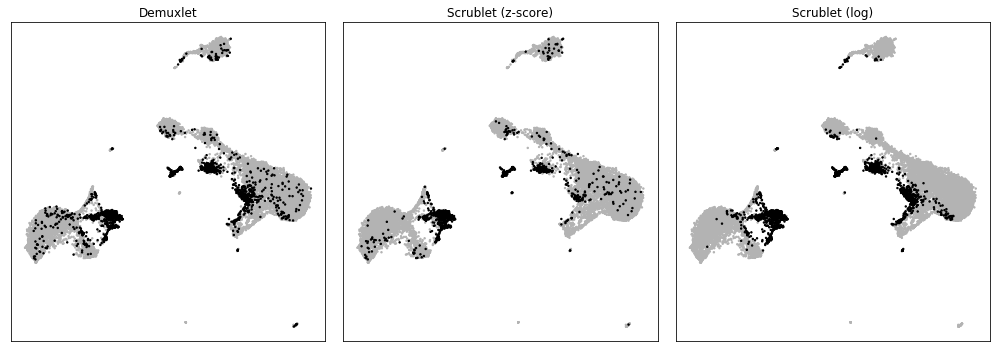

In [10]:


doub_scores = {'Scrublet (z-score)': scrublet_results_zNorm['doublet_scores_observed_cells'], 
               'Scrublet (log)': scrublet_results_logNorm['doublet_scores_observed_cells']
              }

doub_calls = {'Demuxlet': demuxlet_calls,
              'Scrublet (z-score)': scrublet_results_zNorm['doublet_scores_observed_cells'] > score_threshold_zNorm, 
              'Scrublet (log)': scrublet_results_logNorm['doublet_scores_observed_cells'] > score_threshold_logNorm,
              }



x = embedding_logNorm[:,0]
y = embedding_logNorm[:,1]

fig, axs = plt.subplots(1, 3, figsize = (14, 5))
for iMethod, method in enumerate(doub_calls):
    coldat = doub_calls[method]
    o = np.argsort(coldat)
    #o = np.arange(len(coldat))

    ax = axs[iMethod]
    ax.scatter(x[o], y[o], c = coldat[o], cmap=scr.custom_cmap([[.7,.7,.7], [0,0,0]]), s = 2)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(method)
fig.tight_layout()

Compute some metrics to compare predictions to ground truth.  
For this dataset, log normalization improves recall without hurting precision.

In [11]:
from sklearn.metrics import roc_auc_score

print('{:20s}  Recall   Precision   ROC'.format('Method'))
for method in doub_scores:
    recall = sum(doub_calls['Demuxlet'] & doub_calls[method]) / sum(doub_calls['Demuxlet'])
    precision = sum(doub_calls['Demuxlet'] & doub_calls[method]) / sum(doub_calls[method])
    roc = roc_auc_score(doub_calls['Demuxlet'], doub_scores[method])
    print('{:20s}  {:.3f}    {:.3f}       {:.3f}'.format(method, recall, precision, roc))

Method                Recall   Precision   ROC
Scrublet (z-score)    0.479    0.634       0.876
Scrublet (log)        0.765    0.652       0.933
